In [ ]:
# import library
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the data
train = pd.read_csv('./data/train_2016_v2.csv')
prop = pd.read_csv('./data/properties_2016.csv')
sample = pd.read_csv('./data/sample_submission.csv')

In [ ]:
# Data Preprocessing
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# Create training and validation dataset
split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

# Build DMatrix
d_train = xgb.DMatrix(x_train, label = y_train)
d_valid = xgb.DMatrix(x_valid, label = y_valid)

In [ ]:
# Train Model
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.06861	valid-mae:0.06653
[10]	train-mae:0.06843	valid-mae:0.06641
[20]	train-mae:0.06831	valid-mae:0.06636
[30]	train-mae:0.06821	valid-mae:0.06632
[40]	train-mae:0.06814	valid-mae:0.06634
[50]	train-mae:0.06808	valid-mae:0.06636
[60]	train-mae:0.06803	valid-mae:0.06639
[70]	train-mae:0.06800	valid-mae:0.06641
[80]	train-mae:0.06796	valid-mae:0.06643
[90]	train-mae:0.06793	valid-mae:0.06645
[100]	train-mae:0.06791	valid-mae:0.06647
[110]	train-mae:0.06790	valid-mae:0.06650
[120]	train-mae:0.06788	valid-mae:0.06652
[130]	train-mae:0.06787	valid-mae:0.06655
[131]	train-mae:0.06787	valid-mae:0.06655


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import optuna

# Define the objective function
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    # Train the model
    model = xgb.train(params, d_train, num_boost_round=1000, evals=watchlist,
                      early_stopping_rounds=100, verbose_eval=False)

    # Return the best validation MAE
    val_mae = model.best_score
    return val_mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best parameters
print(f"Best Parameters: {study.best_params}")

[I 2024-08-07 16:20:36,810] A new study created in memory with name: no-name-af30606b-e4ea-47d8-b575-6f7d2e5093ea
[I 2024-08-07 16:20:44,375] Trial 0 finished with value: 0.06632165687899683 and parameters: {'eta': 0.06849689837284184, 'max_depth': 5, 'subsample': 0.7598913050375351, 'colsample_bytree': 0.6148338420438869, 'n_estimators': 137, 'lambda': 2.8330317323948166e-05, 'alpha': 0.0002382845754602931}. Best is trial 0 with value: 0.06632165687899683.
[I 2024-08-07 16:20:57,817] Trial 1 finished with value: 0.06633775616994857 and parameters: {'eta': 0.051331420488147775, 'max_depth': 2, 'subsample': 0.6373842536524815, 'colsample_bytree': 0.7526470320189707, 'n_estimators': 809, 'lambda': 6.512511670733965e-06, 'alpha': 6.197197532090262e-08}. Best is trial 0 with value: 0.06632165687899683.
[I 2024-08-07 16:21:00,563] Trial 2 finished with value: 0.06643820492325264 and parameters: {'eta': 0.035750545109714836, 'max_depth': 7, 'subsample': 0.8879438650275757, 'colsample_bytree'

Best Parameters: {'eta': 0.05908833142991288, 'max_depth': 3, 'subsample': 0.820927736572259, 'colsample_bytree': 0.6447406967781748, 'n_estimators': 187, 'lambda': 0.25820779655334664, 'alpha': 0.031225768186557524}


In [ ]:
import optuna.visualization as vis

# Optimization history plot
opt_history_fig = vis.plot_optimization_history(study)
opt_history_fig.show()

# Parameter importance plot
param_importance_fig = vis.plot_param_importances(study)
param_importance_fig.show()

# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'verbose' : 0
}

num_boost_rounds=100
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,10)
    for min_child_weight in range(2,8)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        dict(params,verbose=0),
        d_train,
        num_boost_round=num_boost_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=5, min_child_weight=2
	MAE 0.06835633808222193 for 1 rounds
CV with max_depth=5, min_child_weight=3
	MAE 0.06834819496040144 for 1 rounds
CV with max_depth=5, min_child_weight=4
	MAE 0.06836065108429466 for 1 rounds
CV with max_depth=5, min_child_weight=5
	MAE 0.06835570702919941 for 1 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.0683555758379458 for 1 rounds
CV with max_depth=5, min_child_weight=7
	MAE 0.06834392948028982 for 1 rounds
CV with max_depth=6, min_child_weight=2
	MAE 0.06841180183753023 for 1 rounds
CV with max_depth=6, min_child_weight=3
	MAE 0.06842406997628277 for 1 rounds
CV with max_depth=6, min_child_weight=4
	MAE 0.06842136717618415 for 0 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.0684365967656122 for 0 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.06843341621617874 for 0 rounds
CV with max_depth=6, min_child_weight=7
	MAE 0.06843432939630148 for 1 rounds
CV with max_depth=7, min_child_weight=2
	MAE 0.06845538340170897 f

In [ ]:
# Best Parameters: {'eta': 0.0119131565156289, 'max_depth': 9, 'subsample': 0.8429612774005385, 'colsample_bytree': 0.6712648158059012, 'n_estimators': 707, 'lambda': 0.369304979971096, 'alpha': 0.9702411518148251}
# Train Model
"""
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1
"""
#params = {'eta': 0.0119131565156289, 'max_depth': 9, 'subsample': 0.8429612774005385, 'colsample_bytree': 0.6712648158059012, 'n_estimators': 707, 'lambda': 0.369304979971096, 'alpha': 0.9702411518148251}
params = {'eta': 0.05908833142991288, 'max_depth': 3, 'subsample': 0.820927736572259, 'colsample_bytree': 0.6447406967781748, 'n_estimators': 187, 'lambda': 0.25820779655334664, 'alpha': 0.031225768186557524}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.06858	valid-mae:0.06650
[10]	train-mae:0.06832	valid-mae:0.06632
[20]	train-mae:0.06821	valid-mae:0.06630
[30]	train-mae:0.06811	valid-mae:0.06630
[40]	train-mae:0.06808	valid-mae:0.06632
[50]	train-mae:0.06805	valid-mae:0.06637
[60]	train-mae:0.06802	valid-mae:0.06639
[70]	train-mae:0.06801	valid-mae:0.06644
[80]	train-mae:0.06797	valid-mae:0.06648
[90]	train-mae:0.06794	valid-mae:0.06653
[100]	train-mae:0.06794	valid-mae:0.06657
[110]	train-mae:0.06792	valid-mae:0.06659
[120]	train-mae:0.06791	valid-mae:0.06660
[125]	train-mae:0.06789	valid-mae:0.06660


<Axes: >

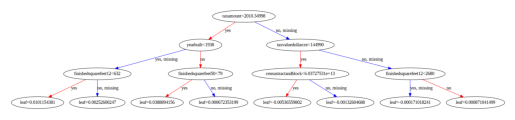

In [ ]:
xgb.plot_tree(clf, num_trees=2)

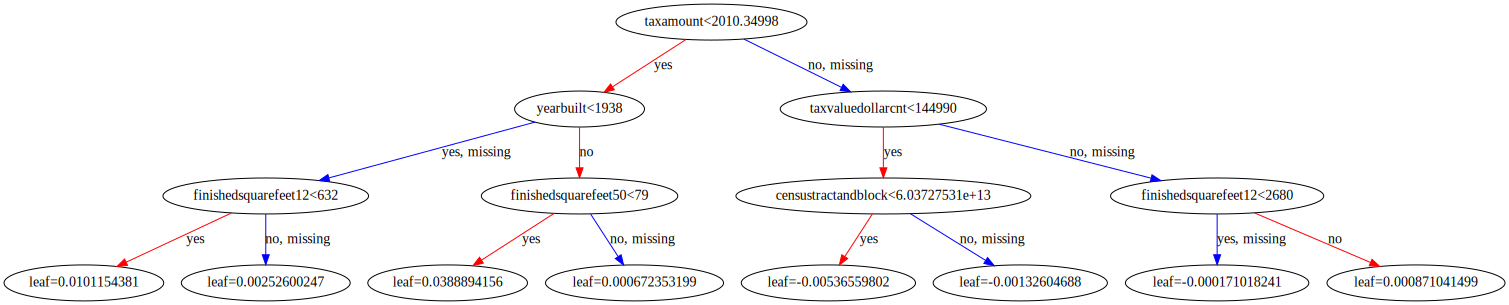

In [ ]:
xgb.to_graphviz(clf, num_trees=2)

In [ ]:
# Run on test data
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how = 'left')

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)

In [ ]:
# Create submission file
sub = pd.read_csv('./data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('xgb.csv', index=False, float_format='%.4f')